In [1]:
from torch_geometric.datasets import QM9
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import logging
import time
import wandb
wandb.login()
import random

import os.path as osp

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import GRU, Linear, ReLU, Sequential
import torch.optim as optim

import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, MessagePassing, global_mean_pool, aggr, GATConv
from torch_geometric.utils import remove_self_loops

wandb: Network error (ConnectionError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Each model and target combination was trained using a uniform random hyper parameter search with 50 trials. 

T was costrained to be in the range 3 ≤ T ≤ 8 (in practice, any T ≥ 3 works). 

The number of set2set computations M was chosen from the range 1 ≤ M ≤ 12. 

All models were trained using SGD with the ADAM optimizer (Kingma &Ba (2014)), with batch size 20 for 3 million steps ( 540 epochs). 

The initial learning rate was chosen uniformly between 1e−5 and 5e−4. We used a linear learning rate decay that began between 10% and 90% of the way through training and the initial learning rate l decayed to a final learning ate l ∗ F, using a decay factor F in the range [.01, 1].

The QM-9 dataset has 130462 molecules in it. We randomly chose 10000 samples for validation, 10000 samples or testing, and used the rest for training. We use the validation set to do early stopping and model selection and we eport scores on the test set. 

All targets were normalized o have mean 0 and variance 1. We minimize the mean quared error between the model output and the target, although we evaluate mean absolute error.

In [2]:
target = 0 # the first property is the one to be predicted

class TargetTransform:
    def __call__(self, data):
        # Specify target.
        data.y = data.y[:, target]
        return data

path = './datasets/QM9'
transform = T.Compose([TargetTransform(), T.Distance(norm=False)]) # add the distance into edge attributes
dataset = QM9(path, transform=transform)

In [3]:
data = dataset[0]
print('After transformation:')
print(data)
print(data.edge_index)
print(data.edge_attr)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

After transformation:
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919]])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
model_name = "b128_e100_r001_adam_mse_msgMean_edgeAttr_poolMaxAggr_2fc_wandb"

In [8]:
config = {
    "in_channels": dataset.num_features,
    "out_channels": 1,
    "hidden_dim_1": 64,
    "hidden_dim_2": 128,
    "hidden_dim_3": 32,
    "lr": 0.001,
    "batch_size": 128,
    "num_epochs": 100,
    "criterion": nn.MSELoss(),
    #"nnconv_aggr": 'mean',
    }

wandb.init(
    # set the wandb project where this run will be logged
    project=model_name,
    
    # track hyperparameters and run metadata
    config=config
)

In [9]:
logging.basicConfig(filename = model_name+'.log',
                    level = logging.INFO,
                    format = '%(asctime)s:%(levelname)s:%(message)s')
 
logging.info(config)

In [10]:
# Split datasets.
torch.manual_seed(12345)
dataset = dataset.shuffle()
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:]
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False) #10000
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False) #10000
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True) #110831

In [11]:
train_dataset[0]

Data(x=[13, 11], edge_index=[2, 28], edge_attr=[28, 5], y=[1], pos=[13, 3], idx=[1], name='gdb_49057', z=[13])

By defining the message() and update() functions, you control how information is propagated through the graph and how nodes update their representations based on the received messages. These functions enable the GNN to learn from the graph structure and capture useful information for the prediction task.

During the forward() pass, the GNN iteratively performs message passing and aggregation steps across the graph, combining information from neighboring nodes to update each node's representation. The output of the forward() function provides the final representations that can be further processed or used for downstream tasks.

In [12]:
# Define the customized message passing layer
class GNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin2 = nn.Linear(5, out_channels)

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, edge_attr=edge_attr,x=x)

    def message(self, x_j, edge_attr):
        return self.lin(x_j)+self.lin2(edge_attr) # can use different operators and assign them different weights
        #represents the feature representations of the neighboring nodes.
    
    def update(self, aggr_out):
        return aggr_out

# Define the GNN-based model
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_dim_1, hidden_dim_2, hidden_dim_3, out_channels):
        super(GNNModel, self).__init__()
        self.gnn = GNN(in_channels, hidden_dim_1)
        self.global_pool = aggr.MaxAggregation()
        self.fc1 = nn.Linear(hidden_dim_1, hidden_dim_3)
        self.fc2 = nn.Linear(hidden_dim_3, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gnn(x, edge_index, edge_attr).relu()
        x = self.global_pool(x,batch)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

In [16]:
# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_dim_1, hidden_dim_2, hidden_dim_3, out_channels):
        super(GNNModel, self).__init__()
        #nn – A neural network that maps edge features edge_attr of shape [-1, num_edge_features] to shape [-1, in_channels * out_channels], e.g., defined by torch.nn.Sequential.
        nn1 = nn.Sequential(nn.Linear(5, 128), ReLU(), nn.Linear(128, in_channels * hidden_dim_1)) # maps to in_channels * out_channels
        self.conv1 = NNConv(in_channels, hidden_dim_1, nn1, aggr=config["nnconv_aggr"]) #11*64
        self.global_pool = aggr.MaxAggregation()
        self.fc1 = nn.Linear(hidden_dim_1, hidden_dim_3)
        self.fc2 = nn.Linear(hidden_dim_3, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_attr).relu()
        #x = global_mean_pool(x, batch)  # size = [batch_size, hidden_channels]
        x = self.global_pool(x,batch)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

In [13]:
# Initialize the model, optimizer, and loss function
model = GNNModel(config["in_channels"], config["hidden_dim_1"], config["hidden_dim_2"], config["hidden_dim_3"], config["out_channels"])
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
print(model)
logging.info(model)

GNNModel(
  (gnn): GNN()
  (global_pool): MaxAggregation()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test before training
model.eval()
total_test_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data).flatten()
        test_loss = config["criterion"](output, data.y)
        total_test_loss += test_loss.item() * data.num_graphs

average_test_loss_before = total_test_loss / len(test_loader.dataset)
print(f'Test Loss before training: {average_test_loss_before:.4f}')
logging.info(f'Test Loss before training: {average_test_loss_before:.4f}')

t0 = time.time()
# Training loop
model.to(device)
model.train()

min_valid_loss = np.inf
loss_values = []
val_loss_values = []

for epoch in range(config["num_epochs"]):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch).flatten()
        loss = config["criterion"](output, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    average_loss = total_loss  / len(train_loader.dataset)
    loss_values.append(average_loss)
    print(f'Epoch: {epoch}, Training Loss: {average_loss:.4f}')
    logging.info(f'Epoch: {epoch}, Training Loss: {average_loss:.4f}')
    
    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data).flatten()
            val_loss = config["criterion"](output, data.y)
            total_val_loss += val_loss.item() * data.num_graphs

    average_val_loss = total_val_loss / len(val_loader.dataset)
    val_loss_values.append(average_val_loss)
    print(f'Epoch: {epoch}, Validation Loss: {average_val_loss:.4f}')
    logging.info(f'Epoch: {epoch}, Validation Loss: {average_val_loss:.4f}')
    # log metrics to wandb
    wandb.log({"epoch":epoch, "train_loss": average_loss, "validation_loss": average_val_loss})
    
    # Update model if validation improved
    if min_valid_loss > average_val_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.4f} ---> {average_val_loss:.4f}) \t Saving The Model')
        min_valid_loss = average_val_loss
        # Saving State Dict
        config["model_state"] = model.state_dict()
        FILE_path = "model_"+model_name+".pth"
        torch.save(config, FILE_path)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print(f'Training time: {time.time()-t0}')
logging.info(f'Training time: {time.time()-t0}')

Test Loss before training: 12.2103
Epoch: 0, Training Loss: 1.7040
Epoch: 0, Validation Loss: 1.3203
Validation Loss Decreased(inf ---> 1.3203) 	 Saving The Model
Epoch: 1, Training Loss: 1.2605
Epoch: 1, Validation Loss: 1.2706
Validation Loss Decreased(1.3203 ---> 1.2706) 	 Saving The Model
Epoch: 2, Training Loss: 1.2281
Epoch: 2, Validation Loss: 1.2351
Validation Loss Decreased(1.2706 ---> 1.2351) 	 Saving The Model
Epoch: 3, Training Loss: 1.2170
Epoch: 3, Validation Loss: 1.2218
Validation Loss Decreased(1.2351 ---> 1.2218) 	 Saving The Model
Epoch: 4, Training Loss: 1.2111
Epoch: 4, Validation Loss: 1.2230
Epoch: 5, Training Loss: 1.1998
Epoch: 5, Validation Loss: 1.2167
Validation Loss Decreased(1.2218 ---> 1.2167) 	 Saving The Model
Epoch: 6, Training Loss: 1.1895
Epoch: 6, Validation Loss: 1.2433
Epoch: 7, Training Loss: 1.1803
Epoch: 7, Validation Loss: 1.2080
Validation Loss Decreased(1.2167 ---> 1.2080) 	 Saving The Model
Epoch: 8, Training Loss: 1.1726
Epoch: 8, Validati

Epoch: 91, Training Loss: 1.0075
Epoch: 91, Validation Loss: 1.0186
Epoch: 92, Training Loss: 1.0086
Epoch: 92, Validation Loss: 1.0179
Epoch: 93, Training Loss: 1.0069
Epoch: 93, Validation Loss: 1.0080
Validation Loss Decreased(1.0144 ---> 1.0080) 	 Saving The Model
Epoch: 94, Training Loss: 1.0086
Epoch: 94, Validation Loss: 1.0182
Epoch: 95, Training Loss: 1.0036
Epoch: 95, Validation Loss: 1.0123
Epoch: 96, Training Loss: 1.0022
Epoch: 96, Validation Loss: 1.0097
Epoch: 97, Training Loss: 1.0046
Epoch: 97, Validation Loss: 1.0163
Epoch: 98, Training Loss: 1.0019
Epoch: 98, Validation Loss: 1.0194
Epoch: 99, Training Loss: 1.0013
Epoch: 99, Validation Loss: 1.0633


wandb: Network error (ConnectionError), entering retry loop.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▄▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,99
train_loss,1.00132
validation_loss,1.06327


Training time: 3191.134992837906


In [20]:
np.savetxt('./loss_values/loss_values_'+model_name+'.txt',loss_values)
np.savetxt('./loss_values/val_loss_values_'+model_name+'.txt',val_loss_values)

In [21]:
loss_values = np.loadtxt("./loss_values/loss_values_"+model_name+".txt")
valid_loss_values = np.loadtxt("./loss_values/val_loss_values_"+model_name+".txt")

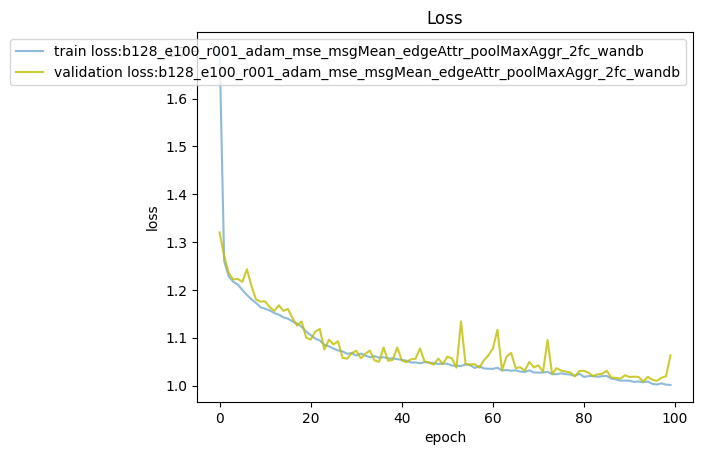

In [22]:
plt.plot(loss_values, label='train loss:'+model_name, ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values,'y', label='validation loss:'+model_name, ls='-', ms=20, markevery=100, alpha=0.8)

#don't know why the markevery doesn't work
plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title("Loss")
plt.legend()
plt.show()